#### **Connect to the database where the .csv data file has been imported as a table**

In [1]:
import sqlite3
from sqlite3 import Error


def connection(db_file):
    """ create a database connection to the SQLite database specified
    by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

conn = connection('../data/input/chinook.db')

**A new table is created with the clean records**

In [2]:
def create_clean_sample(conn):
    """
    Creates table with clean records from the sample dataset
    :param conn: connection object
    :return:None
    """
    cur = conn.cursor()
    cur.execute(
        f"""Create TABLE IF NOT EXISTS cleaned_sample AS
            SELECT
            user_id,
            datetime(substr(registration_date , 7, 4) || '-' || substr(registration_date , 4, 2) || '-' || substr(registration_date , 1, 2) || ' ' || substr(registration_date, 12, 2) || ':' || substr(registration_date, 15, 2) || ':' || substr(registration_date, 18, 2)) as registration_date,
            REPLACE(REPLACE(app_version, '#N/A', 'unknown_version'), 'unknown', 'unknown_version') as app_version,
            REPLACE(REPLACE(REPLACE(user_channel, '#N/A', 'unknown_channel'), 'n/a', 'unknown_channel'), 'unknown', 'unknown_channel') as user_channel,
            datetime(substr(submission_date, 7, 4) || '-' || substr(submission_date, 4, 2) || '-' || substr(submission_date, 1, 2) || ' ' || substr(submission_date, 12, 2) || ':' || substr(submission_date, 15, 2) || ':' || substr(submission_date, 18, 2)) as submission_date,
            REPLACE(REPLACE(user_platform, '#N/A', 'unknown_platform'), 'n/a', 'unknown_platform') as user_platform,
            LOWER(REPLACE(REPLACE(City, '#N/A', 'unknown_city'), 'n/a', 'unknown_city')) as city,
            LOWER(Country) as country
            FROM taxfix"""
    )

    return None

create_clean_sample(conn)

#### **What is the most common channel for acquiring users? What is the second most common channel for acquiring users?**

In [3]:
def get_top_n_acquirers(conn, n):
    """
    Selects most successful acquirer channels
    :param conn: connection object
    :param n: number of elements in ranking, descending
    :return:
    """
    cur = conn.cursor()
    cur.execute(
        f"""SELECT user_channel AS channel,
        count(user_id) AS number_users
        FROM cleaned_sample
        GROUP BY user_channel
        ORDER BY number_users DESC 
        LIMIT {n}"""
    )

    rows = cur.fetchall()

    for i, j in enumerate(rows):
        print(f"'{j[0]}' is the {i+1} channel with {j[1]} users acquired")

    return None


#Execute the previously defined function
get_top_n_acquirers(conn, 2)

'organic' is the 1 channel with 9303 users acquired
'uac' is the 2 channel with 5587 users acquired


#### **How much time does it usually take for a user from their registration to submit their tax declaration?**

In [4]:
def get_avg_submission_time(conn):
    """
    Selects and prints the average time a user takes to submit their tax
    declaration since they registered
    :param conn: connection object
    :return: integer of number of average days
    """
    cur = conn.cursor()
    cur.execute(
        f"""
        select 
        round(avg(STRFTIME('%s' ,submission_date) - STRFTIME('%s' ,registration_date)) * 1.0 / 60 / 60) as avg_time
        from cleaned_sample
        where submission_date is not null
        """
    )

    row = cur.fetchall()
    hours = row[0][0]

    print(
        f"Average time a user took to complete their tax submission "
        f"since they've registered was {hours} hours"
    )
    
    return hours


#Execute the previously defined function and assign the value to variable for later user in visualization.
avg_time = get_avg_submission_time(conn)

Average time a user took to complete their tax submission since they've registered was 12.0 hours


In [5]:
avg_time

12.0

#### **Include a data visualization**

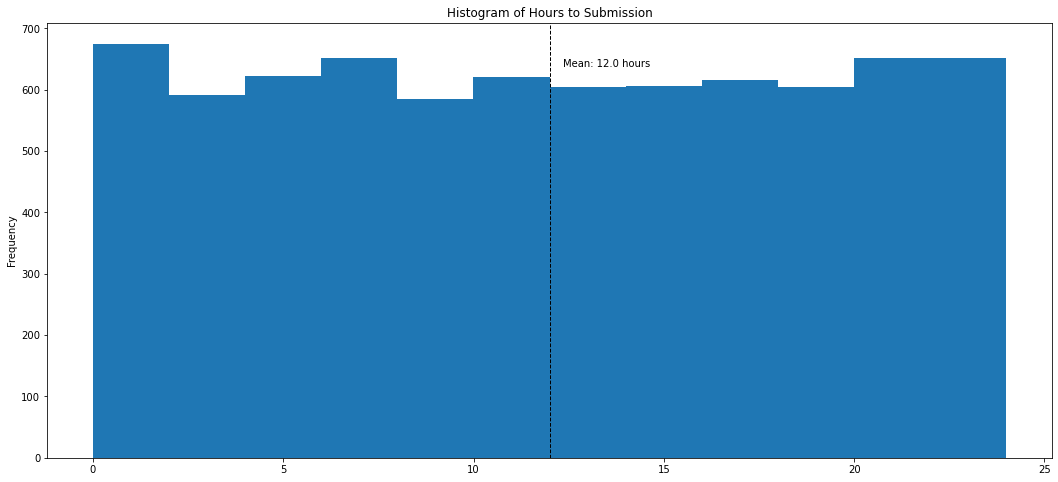

In [6]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt


def get_submission_time_user(conn):
    """
    Provides list user, submission and registration dates, and difference
    :param conn: connection object
    :return:list
    """

    cur = conn.cursor()
    cur.execute(
        f"""
        select 
        user_id,
        submission_date,
        registration_date,
        (STRFTIME('%s' ,submission_date) - STRFTIME('%s' ,registration_date)) *1.0 / 60 / 60 as difference
        from cleaned_sample
        order by difference DESC"""
    )

    rows = cur.fetchall()

    return rows


def create_df(timings_list):

    data = timings_list
    cols = ['user', 'submission_time', 'registration_time', 'hours_difference']
    df_user_timings = pd.DataFrame(data, columns=cols)
    df_user_timings['user'] = df_user_timings['user'].astype('category')

    return df_user_timings


def create_viz(df, constant):
    mean_hours = constant

    series_user_timing = df['hours_difference']
    data_viz = series_user_timing.plot.hist(
        bins=12, figsize=(18, 8), xlabel='days', title='Histogram of Hours to Submission'
    )
    # Plot mean dashed line
    data_viz.axvline(mean_hours, color='k', linestyle='dashed', linewidth=1)

    # Add text to line
    min_ylim, max_ylim = plt.ylim()
    data_viz.text(mean_hours * 1.03, max_ylim * 0.9, f'Mean: {mean_hours} hours')

    # Export viz to .png file
    data_viz.figure.savefig("../data/output/avg_sub_time_user.png", facecolor='w')

    return None


#Execute previously defined function
user_timings = get_submission_time_user(conn)
df_user_timings = create_df(user_timings)
create_viz(df_user_timings, avg_time)

Having a look to the histogram the uniformity of the distribution can be appreciated. The submission time ranges from barely seconds up to almost a whole day, since a user is registered. Thus, based on the sample datase it could be infered that once the user has registered, they have up to 24 hours to submit their tax declaration.

#### **The conversion rate is defined as “users that submit tax declarations” / “users that register”. Try to forecast the future daily values of the conversion rate. How would you take into consideration the seasonality effect?**

In [7]:
def get_raw_table(conn):
    """
    Selects number of registered users, submissions and their relation
    by registration date
    :param conn:connection object
    :return: list of tuples
    """
    cur = conn.cursor()
    cur.execute(
        f"""SELECT * FROM cleaned_sample"""
    )

    rows = cur.fetchall()

    return rows

def 

